In [1]:
import autograd.numpy as np
from autograd import grad, hessian
from autograd import elementwise_grad
from scipy.optimize import fmin_l_bfgs_b, fmin_bfgs, fmin_cg, fmin_ncg
import matplotlib.pyplot as plt
from scipy.linalg import cho_factor, cho_solve, cholesky
from autograd.scipy.linalg import solve_triangular
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.linear_model import LogisticRegression
from autograd.misc.optimizers import adam
import copy
import glob
import imageio
import skimage
from skimage import data, io, filters
from sklearn.model_selection import train_test_split
import pickle
import pandas as pd
import seaborn as sns

In [2]:
def get_labels(filenames):
    labels = np.zeros(len(filenames))
    for i in range(len(filenames)):
        if any(s in filenames[i] for s in ('sad', 'wink', 'surprised', 'sleepy', 'happy')):
            labels[i] = 1
    return labels


img_arr_train = np.array([skimage.img_as_float(skimage.transform.rescale(imageio.imread(file),1.0 / 4.0)) for file in glob.glob('yale_train/*png')])
img_arr_test = np.array([skimage.img_as_float(skimage.transform.rescale(imageio.imread(file),1.0 / 4.0)) for file in glob.glob('yale_test/*png')])
X_train = np.reshape(img_arr_train, (img_arr_train.shape[0], img_arr_train.shape[1]*img_arr_train.shape[2]))
X_test = np.reshape(img_arr_test, (img_arr_test.shape[0], img_arr_test.shape[1]*img_arr_test.shape[2]))
y_train = get_labels(glob.glob('yale_train/*png'))
y_test = get_labels(glob.glob('yale_test/*png'))

/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or Fa

/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or Fa

/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or Fa

In [3]:
def decode_parameters_fast(params, D, latent_dim, opt):
    size_f = D*latent_dim
    f =  params[:size_f]
    #f = f*np.array([0,1]) + np.array([1,0])
    f =  f.reshape(D, latent_dim)
    bias_x = params[size_f:size_f+D]
    if (opt=="ppca"):
        var = params[size_f+D]
        cov_noise= np.ones(D)*np.log(1+np.exp(var))
        #cov_noise= np.diag(np.ones(D)*np.exp(var))
        w = params[size_f+D+1:]
    else:
        var = params[size_f+D:size_f+D*2]
        cov_noise = np.log(1+np.exp(var))
        w = params[size_f+D*2:]
    return f, bias_x, cov_noise, w


def transform_fast(params, x, latent_dim, opt):
    N = x.shape[0]
    D = x.shape[1]
    f, bias_x, cov_noise, w = decode_parameters_fast(params, D, latent_dim, opt)
    L = f.shape[1]
        
    icn = (1.0 / cov_noise).reshape((-1, 1))
    xn = (x - bias_x).T
    Ax = icn * xn
    Au = icn * f
    C = np.eye(L) + np.dot(f.T, Au)
    temp1 = np.dot(f.T, Ax)
    temp1 = np.linalg.solve(C, temp1)
    temp1 = np.dot(Au, temp1)
    temp1 = Ax - temp1
    mean_z = np.dot(f.T, temp1).T 
    return mean_z

def reconstruct_fast(params, x, latent_dim, opt):
    mean_z = transform_fast(params, x, latent_dim, opt)
    D = x.shape[1]
    N = x.shape[0]
    f, bias_x, var_noise, w = decode_parameters_fast(params, D, latent_dim, opt)
    x_new = np.einsum("dl,nl->nd", f, mean_z) + bias_x 
    #noise = np.random.multivariate_normal(np.zeros(D), np.diag(var_noise),  N)
    #x_new = x_new+noise
    #print v
    return x_new 
def compute_ll_fast(params, x, latent_dim, opt):
    N = x.shape[0]
    D = x.shape[1]
    f, bias_x, cov_noise, w = decode_parameters_fast(params, D, latent_dim, opt)
    L = f.shape[1]
        
    icn = (1.0 / cov_noise).reshape((-1, 1))
    xn = (x - bias_x).T
    Ax = icn * xn
    Au = icn * f
    C = np.eye(L) + np.dot(f.T, Au)
    temp1 = np.dot(f.T, Ax)
    temp1 = np.linalg.solve(C, temp1)
    temp1 = np.dot(Au, temp1)
    temp1 = Ax - temp1
    sign, log_det_cov_x = np.linalg.slogdet(C)
    log_det_cov_x += np.sum(np.log(cov_noise))
    
    unnorm_log_pdf_x = np.einsum("dn,dn->n", xn, temp1)
    
    ll = N*D*np.log(2*np.pi)/2 + log_det_cov_x*0.5*N + np.sum(unnorm_log_pdf_x)*0.5 
    return -ll

def sigmoid(x):
    return 1 / (1 + np.exp(-x))



def objective_logit_fast(params, x, y, latent_dim, lambda_e, opt, reg_weight): #check the order of arguments!
    N = x.shape[0]
    D = x.shape[1]
    f, bias_x, cov_noise, w = decode_parameters_fast(params, D, latent_dim, opt)
    L = f.shape[1]
        
    icn = (1.0 / cov_noise).reshape((-1, 1))
    xn = (x - bias_x).T
    Ax = icn * xn
    Au = icn * f
    C = np.eye(L) + np.dot(f.T, Au)
    temp1 = np.dot(f.T, Ax)
    temp1 = np.linalg.solve(C, temp1)
    temp1 = np.dot(Au, temp1)
    temp1 = Ax - temp1
    sign, log_det_cov_x = np.linalg.slogdet(C)
    log_det_cov_x += np.sum(np.log(cov_noise))
    
    unnorm_log_pdf_x = np.einsum("dn,dn->n", xn, temp1)
    
    mean_z = np.dot(f.T, temp1).T
    temp2 = np.einsum("l,nl->n", w[1:], mean_z) + w[0]
    log_bern_pdf_y = np.log(sigmoid(np.multiply((2*y-1),temp2)))
    log_prior = 0 
    reg = reg_weight*np.sum((f/np.sqrt(D))**2) + reg_weight*np.sum(w**2)
    ll = N*D*np.log(2*np.pi)/2 + log_det_cov_x*0.5*N + np.sum(unnorm_log_pdf_x)*0.5 
    obj = ll - lambda_e*np.sum(log_bern_pdf_y) - log_prior + reg
    return obj



def compute_ll_fast(params, x, latent_dim, opt):
    N = x.shape[0]
    D = x.shape[1]
    f, bias_x, cov_noise, w = decode_parameters_fast(params, D, latent_dim, opt)
    L = f.shape[1]
        
    icn = (1.0 / cov_noise).reshape((-1, 1))
    xn = (x - bias_x).T
    Ax = icn * xn
    Au = icn * f
    C = np.eye(L) + np.dot(f.T, Au)
    temp1 = np.dot(f.T, Ax)
    temp1 = np.linalg.solve(C, temp1)
    temp1 = np.dot(Au, temp1)
    temp1 = Ax - temp1
    sign, log_det_cov_x = np.linalg.slogdet(C)
    log_det_cov_x += np.sum(np.log(cov_noise))
    
    unnorm_log_pdf_x = np.einsum("dn,dn->n", xn, temp1)
    
    ll = N*D*np.log(2*np.pi)/2 + log_det_cov_x*0.5*N + np.sum(unnorm_log_pdf_x)*0.5 
    return -ll


def compute_pll_logit_fast(params, x, y, latent_dim, opt):
    N = x.shape[0]
    D = x.shape[1]
    f, bias_x, cov_noise, w = decode_parameters_fast(params, D, latent_dim, opt)
    L = f.shape[1]
        
    icn = (1.0 / cov_noise).reshape((-1, 1))
    xn = (x - bias_x).T
    Ax = icn * xn
    Au = icn * f
    C = np.eye(L) + np.dot(f.T, Au)
    temp1 = np.dot(f.T, Ax)
    temp1 = np.linalg.solve(C, temp1)
    temp1 = np.dot(Au, temp1)
    temp1 = Ax - temp1
    
    mean_z = np.dot(f.T, temp1).T
    temp2 = np.einsum("l,nl->n", w[1:], mean_z) + w[0]
    log_bern_pdf_y = np.log(sigmoid(np.multiply((2*y-1),temp2)))
    return np.sum(log_bern_pdf_y)


    

In [4]:
import re
def get_subjects(filenames):
    subjects = np.zeros(len(filenames))
    for i in range(len(filenames)):
        subjects[i] = int(re.search(r"\d\d", filenames[i]).group(0))
    return subjects

def attribute_category(name):
    if 'sad' in name:
        c = '1' 
    elif    'wink' in name:
        c = '2'
    elif    'surprised' in name:
        c = '3'
    elif    'sleepy' in name: 
        c = '4'
    elif    'happy' in name: 
        c = '5'
    elif    'noglasses' in name:
        c = '-1'
    elif    'normal' in name:
        c = '-2'
    elif    'leftlight' in name:
        c = '-3'
    elif    'rightlight' in name:
        c = '-4'
    else:
        c = '-5'

    return c
def decode_category(category):
    if category == 1:
        c = 'sad' 
    elif category == 2:
        c = 'wink' 
    elif category == 3:
        c = 'surprised'
    elif category == 4:
        c = 'sleepy'
    elif category == 5:
        c = 'happy'
    elif category == -1:
        c = 'noglasses'
    elif category == -2:
        c = 'normal'
    elif category == -3:
        c = 'leftlight'
    elif category == -4:
        c = 'rightlight'
    else:
        c = 'centerlight'
    #print category, c
    return c

def get_categories(filenames):
    categories = []
    for i in range(len(filenames)):
        categories.append(attribute_category(filenames[i]))
    return categories

In [5]:
def plot_reconstructed(df, img_arr_orig, img_arr_rec, idxs, filename, title):
    columns = 8.0
    rows = np.ceil(idxs.shape[0]*2/columns)
    print rows
    fig=plt.figure(figsize=(columns*3, rows*4.5))
    plt.suptitle(title, fontsize  = 18)
    for i in range(idxs.shape[0]):
        fig.add_subplot(rows, columns, 2*i+1)
        plt.title('idx: {} subject: {}\n category: {}'.format(idxs[i], int(df.subject[idxs[i]]), decode_category(int(df.category[idxs[i]]))), fontsize = 12)
        skimage.io.imshow(img_arr_orig[idxs[i]])
        fig.add_subplot(rows, columns, 2*i+2)
        
        skimage.io.imshow(img_arr_rec[idxs[i]], cmap = 'gray')

    plt.savefig(filename)
    plt.show()

In [115]:
latent_dim = 10
opt = "ppca"

with open("params_latent_{}_take_1.pkl".format(latent_dim)) as f:  
    [params_opt_l_bfgs_b, final_obj_val_l_bfgs_b, best_params_opt_l_bfgs_b] = pickle.load(f)   
with open("metrics_latent_{}_take_1.pkl".format(latent_dim)) as f:  
    [test_acc_l_bfgs_b, train_acc_l_bfgs_b, pll_l_bfgs_b_train, pll_l_bfgs_b_test, ll_l_bfgs_b_train, ll_l_bfgs_b_test, reg_weights, pred_weights] = pickle.load(f)   
    

In [82]:
latent_dim = 50
opt = "ppca"

with open("params_latent_{}.pkl".format(latent_dim)) as f:  
    [params_opt_l_bfgs_b, final_obj_val_l_bfgs_b, best_params_opt_l_bfgs_b] = pickle.load(f)   
with open("metrics_latent_{}.pkl".format(latent_dim)) as f:  
    [test_acc_l_bfgs_b, train_acc_l_bfgs_b, pll_l_bfgs_b_train, pll_l_bfgs_b_test, ll_l_bfgs_b_train, ll_l_bfgs_b_test, reg_weights, pred_weights] = pickle.load(f)   
    

In [6]:
latent_dim = 2
opt = "ppca"
with open('/Users/madinaabdrakhmanova/Google Drive/pickle_files/params_logit_all_latent_2_take_2.pkl') as f:  
    [best_params_opt_l_bfgs_b, final_obj_val_l_bfgs_b, test_acc_l_bfgs_b, train_acc_l_bfgs_b, pll_l_bfgs_b_train, pll_l_bfgs_b_test, ll_l_bfgs_b_train, ll_l_bfgs_b_test, reg_weights, pred_weights] = pickle.load(f)   

In [6]:
latent_dim = 2
with open("fa_params_latent_{}.pkl".format(latent_dim)) as f:  
    [params_opt_l_bfgs_b, final_obj_val_l_bfgs_b, best_params_opt_l_bfgs_b, opt] = pickle.load(f)   
with open("fa_metrics_latent_{}.pkl".format(latent_dim)) as f:  
    [test_acc_l_bfgs_b, train_acc_l_bfgs_b, pll_l_bfgs_b_train, pll_l_bfgs_b_test, ll_l_bfgs_b_train, ll_l_bfgs_b_test, reg_weights, pred_weights] = pickle.load(f)   


In [33]:
latent_dim = 2
with open("ppca_fixed_w_params_latent_{}.pkl".format(latent_dim)) as f:  
    [params_opt_l_bfgs_b, final_obj_val_l_bfgs_b, best_params_opt_l_bfgs_b, opt] = pickle.load(f)   
with open("ppca_fixed_w_metrics_latent_{}.pkl".format(latent_dim)) as f:  
    [test_acc_l_bfgs_b, train_acc_l_bfgs_b, pll_l_bfgs_b_train, pll_l_bfgs_b_test, ll_l_bfgs_b_train, ll_l_bfgs_b_test, reg_weights, pred_weights] = pickle.load(f)   


In [11]:
regular_weight_id, pred_weight_id = np.unravel_index(np.argmax(test_acc_l_bfgs_b), (test_acc_l_bfgs_b.shape))
regular_weight_id = 2
pred_weight_id = 5
print test_acc_l_bfgs_b[regular_weight_id, pred_weight_id]
print reg_weights[regular_weight_id]
print pred_weights[pred_weight_id]

x_dim = X_train.shape[1]

f_best, bias_best, cov_noise_best, w_best = decode_parameters_fast(best_params_opt_l_bfgs_b[regular_weight_id, pred_weight_id], x_dim, latent_dim, opt)
clf_pc = LogisticRegression()
clf_pc.coef_ = w_best[1:].reshape(1,  latent_dim)
clf_pc.intercept_ = w_best[0]
clf_pc.classes_ = np.array([0, 1])

X_test_proj = transform_fast(best_params_opt_l_bfgs_b[regular_weight_id, pred_weight_id], X_test, latent_dim, opt)

y_test_pred = clf_pc.predict(X_test_proj)
misclassified_idxs = np.argwhere(y_test_pred!=y_test)[:,0]
correct_classified_idxs = np.argwhere(y_test_pred==y_test)[:,0]

filenames_test = glob.glob('yale_test/*png')
categories_test = get_categories(filenames_test)
subjects_test = get_subjects(filenames_test)

X_test_proj_rec = reconstruct_fast(best_params_opt_l_bfgs_b[regular_weight_id, pred_weight_id], X_test, latent_dim, opt)
img_arr_test_rec = np.reshape(X_test_proj_rec, img_arr_test.shape) 

df_test = pd.DataFrame({
    'pred_labels': y_test_pred,
    'true_labels': y_test,
    'filename': filenames_test,
    'category': categories_test,
    'subject': subjects_test    
    })

filenames_train = glob.glob('yale_train/*png')
categories_train = get_categories(filenames_train)
subjects_train = get_subjects(filenames_train)

X_train_proj_rec = reconstruct_fast(best_params_opt_l_bfgs_b[regular_weight_id, pred_weight_id], X_train, latent_dim, opt)
img_arr_train_rec = np.reshape(X_train_proj_rec, img_arr_train.shape) 

df_train = pd.DataFrame({
    'true_labels': y_train,
    'filename': filenames_train,
    'category': categories_train,
    'subject': subjects_train   
    })

0.675
1000.0
1000000.0


4.0


/anaconda2/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "
/anaconda2/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "
/anaconda2/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "
/anaconda2/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "
/anaconda2/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:

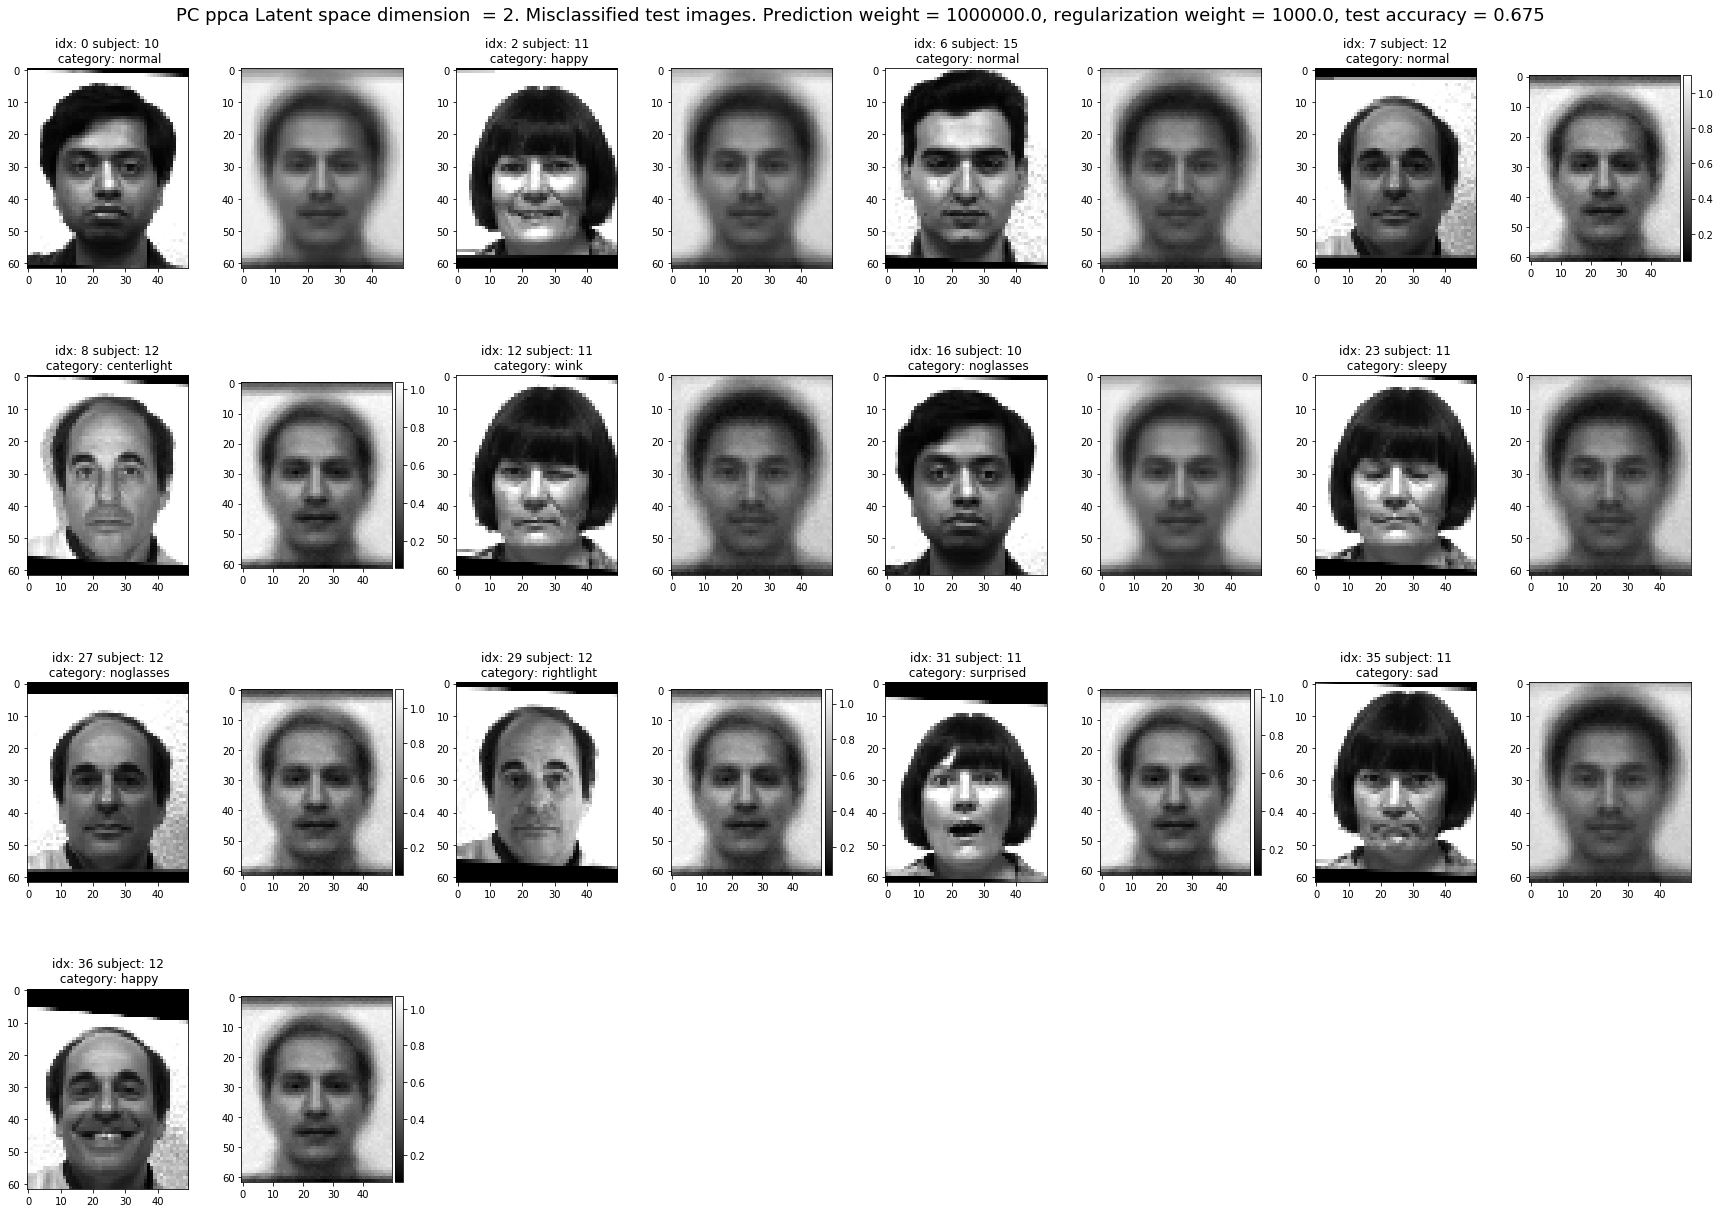

In [12]:

filename = "{}_reconstructed_misclassified_latent{}_pred_weight{}_reg_weight{}.png".format(opt, latent_dim, pred_weights[pred_weight_id], reg_weights[regular_weight_id])
title = "PC {} Latent space dimension  = {}. Misclassified test images. Prediction weight = {}, regularization weight = {}, test accuracy = {}".format(opt, latent_dim, pred_weights[pred_weight_id], reg_weights[regular_weight_id],  test_acc_l_bfgs_b[regular_weight_id, pred_weight_id])

plot_reconstructed(df_test, img_arr_test, img_arr_test_rec, misclassified_idxs, filename, title)


4.0


/anaconda2/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "
/anaconda2/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "
/anaconda2/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "
/anaconda2/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "
/anaconda2/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:

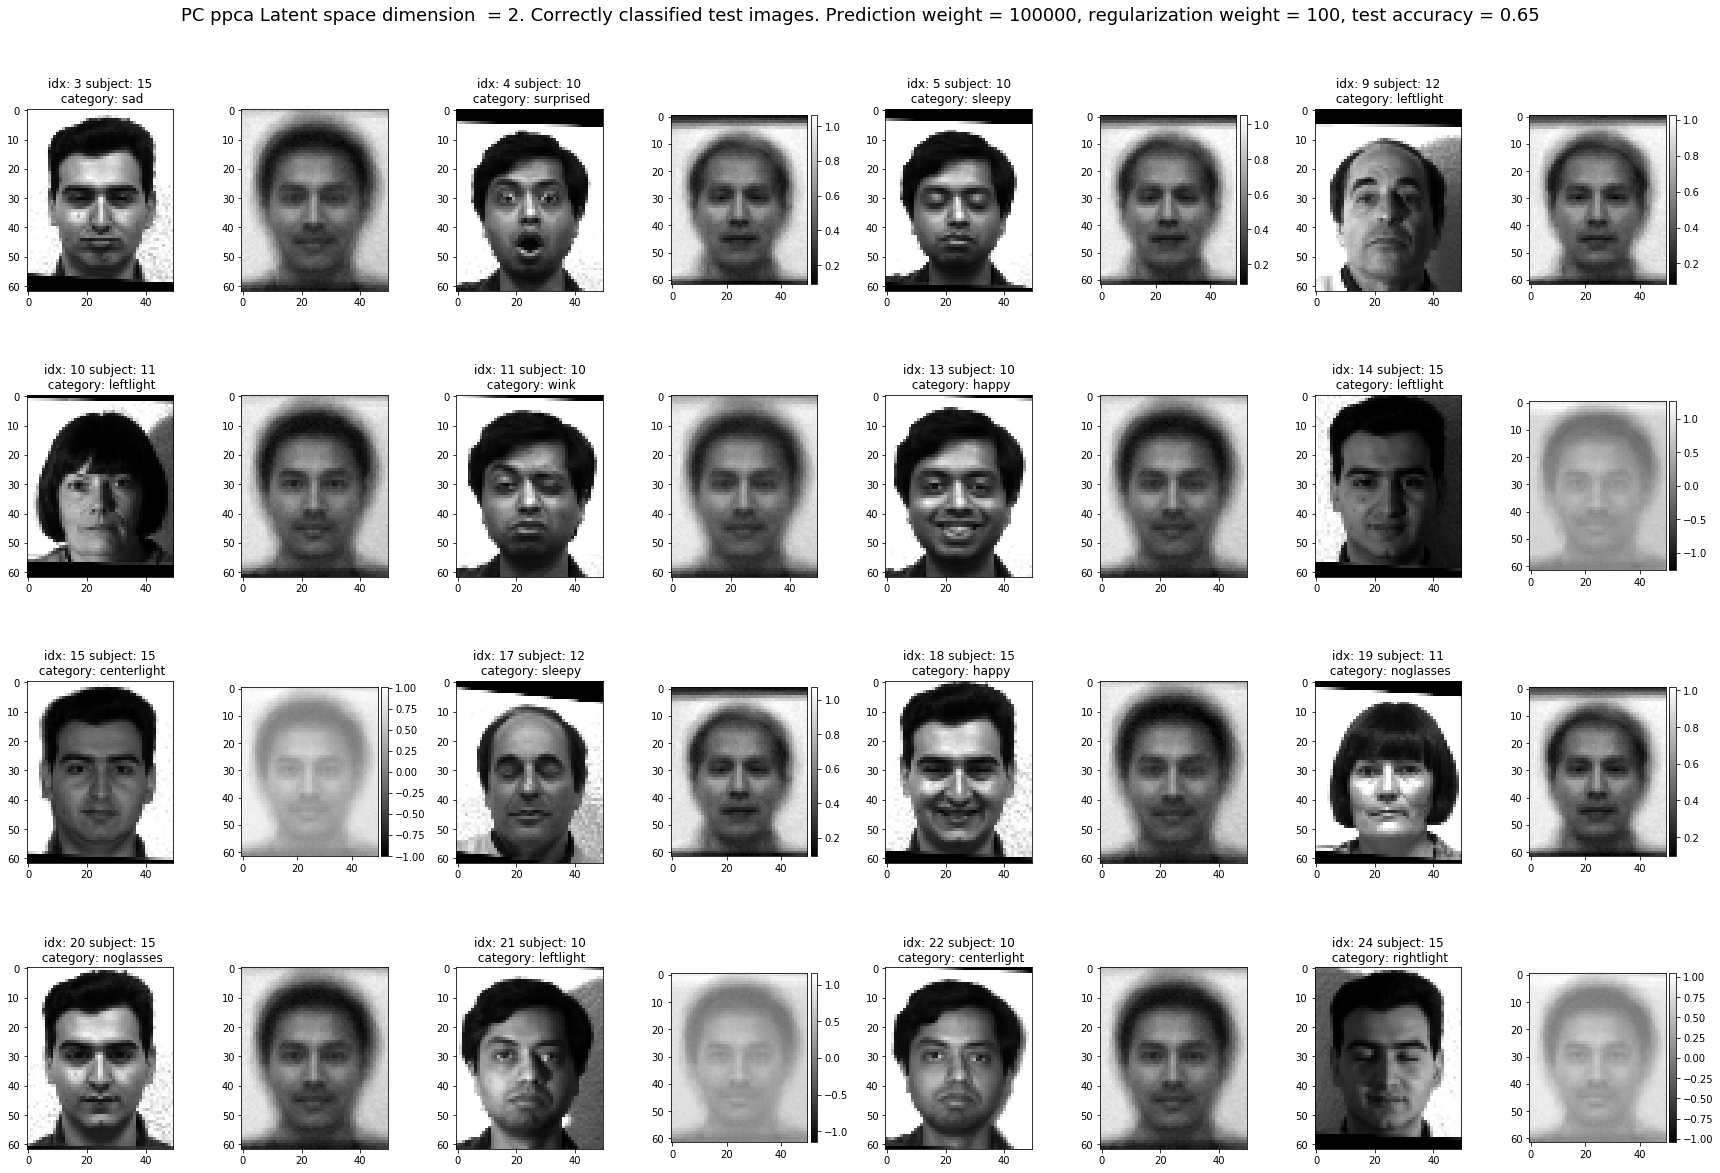

In [42]:
filename = "{}_reconstructed_correct_classified_latent{}_pred_weight{}_reg_weight{}.png".format(opt, latent_dim, pred_weights[pred_weight_id], reg_weights[regular_weight_id])
title = "PC {} Latent space dimension  = {}. Correctly classified test images. Prediction weight = {}, regularization weight = {}, test accuracy = {}".format(opt, latent_dim, pred_weights[pred_weight_id], reg_weights[regular_weight_id],  test_acc_l_bfgs_b[regular_weight_id, pred_weight_id])
plot_reconstructed(df_test, img_arr_test, img_arr_test_rec, correct_classified_idxs[:16], filename, title)


1.0


/anaconda2/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "
/anaconda2/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


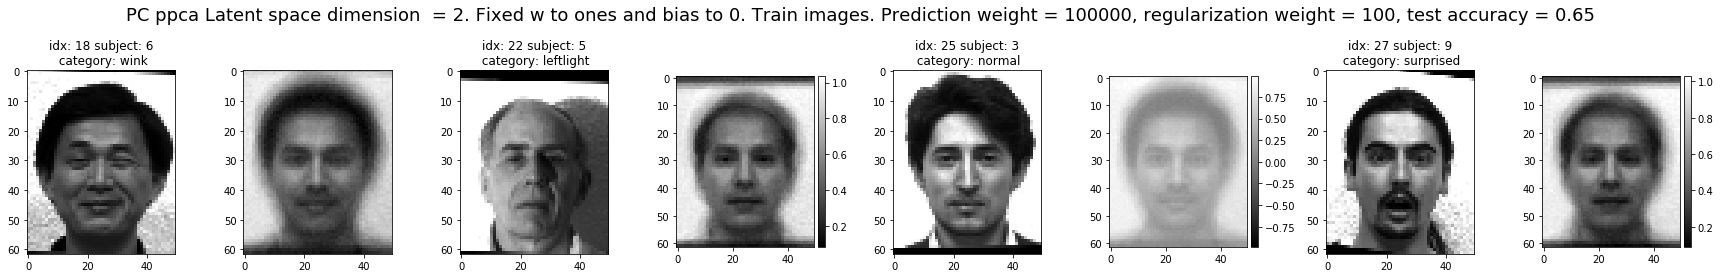

In [43]:
filename = "{}_reconstructed_train_latent{}_pred_weight{}_reg_weight{}.png".format(opt, latent_dim, pred_weights[pred_weight_id], reg_weights[regular_weight_id])
title = "PC {} Latent space dimension  = {}. Fixed w to ones and bias to 0. Train images. Prediction weight = {}, regularization weight = {}, test accuracy = {}".format(opt, latent_dim, pred_weights[pred_weight_id], reg_weights[regular_weight_id],  test_acc_l_bfgs_b[regular_weight_id, pred_weight_id])

#plot_reconstructed(df_train, img_arr_train, img_arr_train_rec, np.arange(img_arr_train.shape[0]*2/10, img_arr_train.shape[0]*2/10+16), filename, title)
plot_reconstructed(df_train, img_arr_train, img_arr_train_rec, np.array([18, 22, 25, 27]), filename, title)

In [118]:
def get_intersection(df, idxs_list):
    inter12 = np.intersect1d(idxs_list[0], idxs_list[1])
    inter34 = np.intersect1d(idxs_list[2], idxs_list[3])
    inter =  np.intersect1d(inter12, inter34)
    return inter

regular_weight_ids = [0,1,2,4]
pred_weight_ids = [6,4,6,-1]
misclassified_idxs = []
for i in range(4):
    regular_weight_id = regular_weight_ids[i]
    pred_weight_id =pred_weight_ids[i]

    _, _, _, w_best = decode_parameters_fast(best_params_opt_l_bfgs_b[regular_weight_id, pred_weight_id], x_dim, latent_dim, opt)
    clf_pc = LogisticRegression()
    clf_pc.coef_ = w_best[1:].reshape(1,  latent_dim)
    clf_pc.intercept_ = w_best[0]
    clf_pc.classes_ = np.array([0, 1])

    X_test_proj = transform_fast(best_params_opt_l_bfgs_b[regular_weight_id, pred_weight_id], X_test, latent_dim, opt)

    y_test_pred = clf_pc.predict(X_test_proj)
    misclassified_idxs.append(np.argwhere(y_test_pred!=y_test)[:,0])
    
inter_idxs =  get_intersection(df_test, misclassified_idxs)
print inter_idxs
for i in range(4):
    regular_weight_id = regular_weight_ids[i]
    pred_weight_id =pred_weight_ids[i]

    X_test_proj_rec = reconstruct_fast(best_params_opt_l_bfgs_b[regular_weight_id, pred_weight_id], X_test, latent_dim, opt)
    img_arr_test_rec = np.reshape(X_test_proj_rec, img_arr_test.shape) 
    filename = "reconstructed_misclassified_latent{}_pred_weight{}_reg_weight{}.png".format(latent_dim, pred_weights[pred_weight_id], reg_weights[regular_weight_id])
    title = "Latent space dimension  = {}. Misclassified test images. Prediction weight = {}, regularization weight = {}, test accuracy = {}".format(latent_dim, pred_weights[pred_weight_id], reg_weights[regular_weight_id],  test_acc_l_bfgs_b[regular_weight_id, pred_weight_id])
    plot_reconstructed(df_test, img_arr_test, img_arr_test_rec, inter_idxs, filename, title)


[ 0  8 16 27]
